In [1]:
# load-in libraries
import nltk
import requests
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
# nltk.download('stopwords')

### Introduction
We'll look at text samples from the plays of William Shakespeare and Ben Jonson, a contemporary of Shakespeare, to see if we can train a model which can accurately determine who the author of a given piece of text is. To do this, we must first pull-in our source data from Project Gutenberg and vectorize the texts. Here, we will consider the individual lines as the observations in order to build a larger dataset and not, then, get to predict on an entire play. This sparsity of data will likely inflate our error more than if we had an entire play, or even act, to identify.

In [2]:
# we'll look at the comedies of each (4 a piece)
source_dict = {'Every Man in his Humour': 'http://www.gutenberg.org/cache/epub/3694/pg3694.txt', 
               'Volpone' : 'http://www.gutenberg.org/cache/epub/4039/pg4039.txt', 
               'The Alchemist': 'http://www.gutenberg.org/cache/epub/4081/pg4081.txt',
               'Bartholomew Fair' : 'http://www.gutenberg.org/cache/epub/49461/pg49461.txt',
               'As You Like It' : 'http://www.gutenberg.org/cache/epub/1121/pg1121.txt', 
                'The Comedy of Errors' : 'https://www.gutenberg.org/files/23046/23046-0.txt', 
                'Twelfth Night' : 'http://www.gutenberg.org/cache/epub/1123/pg1123.txt',
                'Tempest' : 'http://www.gutenberg.org/cache/epub/1135/pg1135.txt'}
author_dict = {'As You Like It': 'Shakespeare', 'The Comedy of Errors':'Shakespeare','Twelfth Night':'Shakespeare',
              'Tempest':'Shakespeare', 'Every Man in his Humour':'Jonson','Volpone':'Jonson', 
               'The Alchemist':'Jonson', 'Bartholomew Fair':'Jonson'}
author_map = {'Jonson' : 0, 'Shakespeare' : 1}

In [3]:
def prepare_text(url_dict, line_size = 12, lines_as_obs = 1):
    data_dict = {'play' : [], 'raw_text' : [], 'author' : []}
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    texts, plays = [], []
    for title, url in url_dict.items():
        r = requests.get(url)
        r.encoding = 'utf-8'
        html = r.text[55000:-20000]  # make sure to remove header & footer w/ licenses & other non-text stuff
        lines = re.split('\n\r|\r\n', html)
        for i in range(0, len(lines), lines_as_obs):
            if len(lines[i]) > line_size:  # remove shorter lines (likely names or stage directions)
                melted_line = ' '.join(w for w in lines[i:i+lines_as_obs])  # add multiple lines if defined
                line_tokenized = tokenizer.tokenize(melted_line.lower())
                data_dict['raw_text'].append(' '.join(w for w in line_tokenized))
                data_dict['play'].append(title)
                data_dict['author'].append(author_dict[title])
    return data_dict

In [4]:
# we'll generate a corpus of one-liners 
text_dict = prepare_text(source_dict, line_size = 50)

# and a multi-line version (thanks to Jiffar for suggestion)
long_text_dict = prepare_text(source_dict, line_size = 50, lines_as_obs = 5)

# check that len(long_text_dict is approx. 1/5 * len(text_dict))
# won't be exact b/c of line exclusion for shorter lines
print(len(text_dict['raw_text']) / 5)
print(len(long_text_dict['raw_text']))

1793.2
1776


In [5]:
# setup our pandas dataframe containing the lines and textual information
import pandas as pd
df = pd.DataFrame(text_dict)
df['label'] = df['author'].map(author_map)
print(df.head())

long_df = pd.DataFrame(long_text_dict)
long_df['label'] = long_df['author'].map(author_map)
print(long_df.head())

                      play                                           raw_text  \
0  Every Man in his Humour     lor se now trust me here s a goodly day toward   
1  Every Man in his Humour  musco call up my son lorenzo bid him rise tell...   
2  Every Man in his Humour    the sovereign use of study what cousin stephano   
3  Every Man in his Humour  step nothing but e en come to see how you do u...   
4  Every Man in his Humour   lor se that s kindly done you are welcome cousin   

   author  label  
0  Jonson      0  
1  Jonson      0  
2  Jonson      0  
3  Jonson      0  
4  Jonson      0  
                      play                                           raw_text  \
0  Every Man in his Humour  step ay i know that sir i would not have come ...   
1  Every Man in his Humour  will i scorn it ay so i do to be a consort for...   
2  Every Man in his Humour  that which your friends have left you but you ...   
3  Every Man in his Humour  of all reclaim ay so now you are told on it yo.

### Vectorizing text
In order to pass-in our lines to a classification model, we need to transform our raw text into numeric vectors. We'll use tf-idf vectorizing which intends to predict the importance of a particular word in a corpus of text. Roughly, the statistic increases by the instances of a particular word and is depressed if that word is present in a large number of lines in the corpus (thus deflating the importance of common words like 'the'). The vector returned is then something we can directly feed into our classification model.

In [6]:
# need to vectorize texts in order to fit our classification model
vectorizer = TfidfVectorizer()
corpus = []
for line in df.raw_text:
    corpus.append(line)
model = vectorizer.fit(corpus)

Now that our text is vectorized, we will be using Logistic Regression to classify lines of text as being written by Ben Jonson or William Shakespeare. The model will learn a weight vector $\vec{w}$ from our input train set of lines and their respective labels. Then, upon feeding it new data $\vec{x}$, the following calculation is performed:
$$
f(x)=\frac{1}{1+e^{-\vec{w}\cdot\vec{x}}}
$$
which returns a value that is then mapped to a label depending on whether its output is closer to 0 or 1. 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2

Now, can we tell if a model considering just one line versus one fitted on multiple lines as observations will perform any better?

In [8]:
# one-line model
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(df['raw_text'], df['label'], test_size = TEST_SIZE)
X_train_one, X_test_one = vectorizer.transform(X_train_one), vectorizer.transform(X_test_one)

# insert use of cross-validation

lr_one = LogisticRegression(solver = 'lbfgs')
lr_one.fit(X_train_one, y_train_one)
# what's the accuracy on our training data?
score = lr_one.score(X_train_one, y_train_one)
print("Testing accuracy of single line model: {}".format(round(score,6)))

Testing accuracy of single line model: 0.874233


In [10]:
# multi-line model
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(long_df['raw_text'], long_df['label'], test_size = TEST_SIZE)
X_train_multi, X_test_multi = vectorizer.transform(X_train_multi), vectorizer.transform(X_test_multi)

# insert use of cross-validation

lr_multi = LogisticRegression(solver = 'lbfgs')
lr_multi.fit(X_train_multi, y_train_multi)
# what's the accuracy on our training data?
score = lr_multi.score(X_train_multi, y_train_multi)
print("Testing accuracy of multi-line model: {}".format(round(score,6)))

Testing accuracy of multi-line model: 0.867606


Appears that at least with respect to the training data there is not much differnece. Now, that we have our weights $\vec{w}$ we can test them on our outstanding raw lines data and visualize the accuracy of our model.

In [11]:
from sklearn.metrics import accuracy_score
import numpy as np

y_pred_one = lr_one.predict(X_test_one)
y_pred_multi = lr_multi.predict(X_test_multi)

# what's the accuracy on our test data?
print("Accuracy of single line model: {}".format(round(accuracy_score(y_test_one, y_pred_one),6)))
print("Accuracy of multi-line model: {}".format(round(accuracy_score(y_test_multi, y_pred_multi),6)))

Accuracy of single line model: 0.839465
Accuracy of multi-line model: 0.808989


The usage of cross-validation allows us to iteratively create partitions of our data in order to train & test the model on. This can give us a more robust sense of the performance of our model on different 'slices' of our data, as it were.

In [12]:
from sklearn.model_selection import cross_val_score
transformed_text = vectorizer.transform(df['raw_text'])
cv_scores = cross_val_score(lr_one, transformed_text, df['label'], cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy: 0.79 (+/- 0.05)


We have explored the problem of overfitting throughout various models and here we will likely experience the same problem. We can iterate our model over a range of decreasing test sizes and demonstrate that even though it generally increases the accuracy on our in-sample training data, it can have the inverse effect on our testing data.

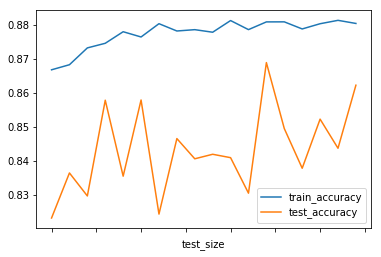

In [14]:
# iterate over test sizes and plot accuracy to demonstrate overfitting
result_dict = {'test_size' :[], 'train_accuracy' : [], 'test_accuracy' : []}
for denom in range(2,20):
    size = 1 / denom
    result_dict['test_size'].append(str(size))
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df['raw_text'], df['label'], test_size = size)
    X_train_tmp = vectorizer.transform(X_train_tmp)
    X_test_tmp = vectorizer.transform(X_test_tmp)
    lr_tmp = LogisticRegression(solver = 'lbfgs')
    lr_tmp.fit(X_train_tmp, y_train_tmp)
    y_pred_tmp = lr_tmp.predict(X_test_tmp)
    result_dict['train_accuracy'].append(lr_tmp.score(X_train_tmp, y_train_tmp))
    result_dict['test_accuracy'].append(accuracy_score(y_test_tmp, y_pred_tmp))
result_df = pd.DataFrame(result_dict)
result_df.set_index('test_size', inplace = True)
_ = result_df.plot()

Finally, an ROC (Receiver Operating Characteristic) curve, is perhaps a more informative visualization of the predictor we have build as it considers the False positive and True positive rates. Therefore, it is at least providing more information than an accuracy score which only informs us how many samples were correctly ID'ed. 

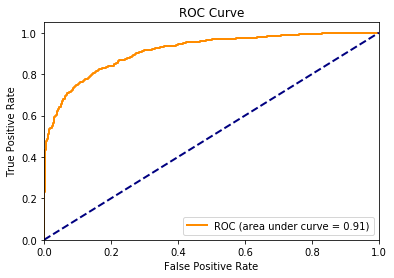

In [21]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score = lr_one.decision_function(X_test_one)
fpr, tpr, thresholds = roc_curve(y_test_one, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC (area under curve = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
_ = plt.title('ROC Curve')